# Interpretation of Logistic Regression

In [1]:
import os

# Change the current working directory
os.chdir('files')

In [2]:
# Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

DATASET: https://www.kaggle.com/datasets/missionjee/car-sales-report

In [3]:
# Read csv file
df = pd.read_csv('car_data.csv')

# Clean dataset
df = df[['Gender','Annual Income', 'Company', 'Transmission','Color','Body Style']]
df = df.dropna()

# Transform gender to binary
df['gender-binary'] = np.where(df['Gender'] == 'Female', 1, 0)
Y = df['gender-binary']

# Categorical variables to matrix
scaler = StandardScaler()

company = pd.get_dummies(df['Company'])
color = pd.get_dummies(df['Color'])

# Merge categorical variables
X_cat = pd.concat([company, color], axis = 1)
X_cat = X_cat.astype(int)

# Scale numerical values
X_num = scaler.fit_transform(df['Annual Income'].values.reshape(-1,1))
X_num = pd.DataFrame(X_num, columns = ['Annual income'])

# Merge categorical and numerical variables
X = pd.concat([X_cat, X_num], axis = 1)

# Add constant
X_const = sm.add_constant(X)

In [4]:
df

,Gender,Annual Income,Company,Transmission,Color,Body Style,gender-binary
0,Male,13500,Ford,Auto,Black,SUV,0
1,Male,1480000,Dodge,Auto,Black,SUV,0
2,Male,1035000,Cadillac,Manual,Red,Passenger,0
3,Male,13500,Toyota,Manual,Pale White,SUV,0
4,Male,1465000,Acura,Auto,Red,Hatchback,0
...,...,...,...,...,...,...,...
23901,Male,13500,Plymouth,Manual,Red,Passenger,0
23902,Female,900000,Chevrolet,Auto,Black,Hardtop,1
23903,Male,705000,BMW,Manual,Red,Sedan,0
23904,Male,13500,Chevrolet,Auto,Black,Passenger,0


#### i) The `Homogeneous Probability` model:

#### Fit a logistic regression model with just an intercept, no other covariates. Plot the empirical posterior distribution of the baseline coefficients: a) on the log-odds scale; b) on the odds scale; c) on the probability scale. Interpret this result. 

In [5]:
# Fit the model 
model = sm.Logit(Y, X_const['const']).fit()

Optimization terminated successfully.
         Current function value: 0.518779
         Iterations 5


In [6]:
# Get summary results
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:          gender-binary   No. Observations:                23906
Model:                          Logit   Df Residuals:                    23905
Method:                           MLE   Df Model:                            0
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:               4.118e-12
Time:                        11:19:56   Log-Likelihood:                -12402.
converged:                       True   LL-Null:                       -12402.
Covariance Type:            nonrobust   LLR p-value:                       nan
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.3029      0.016    -82.576      0.000      -1.334      -1.272


In [7]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
coef_mean = model.params
coef_cov = model.cov_params()

In [8]:
(coef_mean,coef_cov)

(const   -1.302943
 dtype: float64,
           const
 const  0.000249)

In [9]:
# Number of simulations
n = 1000

# Simulate beta coefficients:

# on the log-odds scale
# Random variable that is from multivariate normal distribution
simulated_base_log_odds = multivariate_normal.rvs(mean= coef_mean, cov = coef_cov, size = n)

# on the odds scale
simulated_base_odds = np.exp(simulated_base_log_odds)

# on the probability scale, from 0 to 1
simulated_base_prob = logistic_sigmoid(simulated_base_log_odds)

# simulations array, stacks (joins) 3 arrays together
simulated_base = np.stack((simulated_base_log_odds, simulated_base_odds, simulated_base_prob), axis=1)

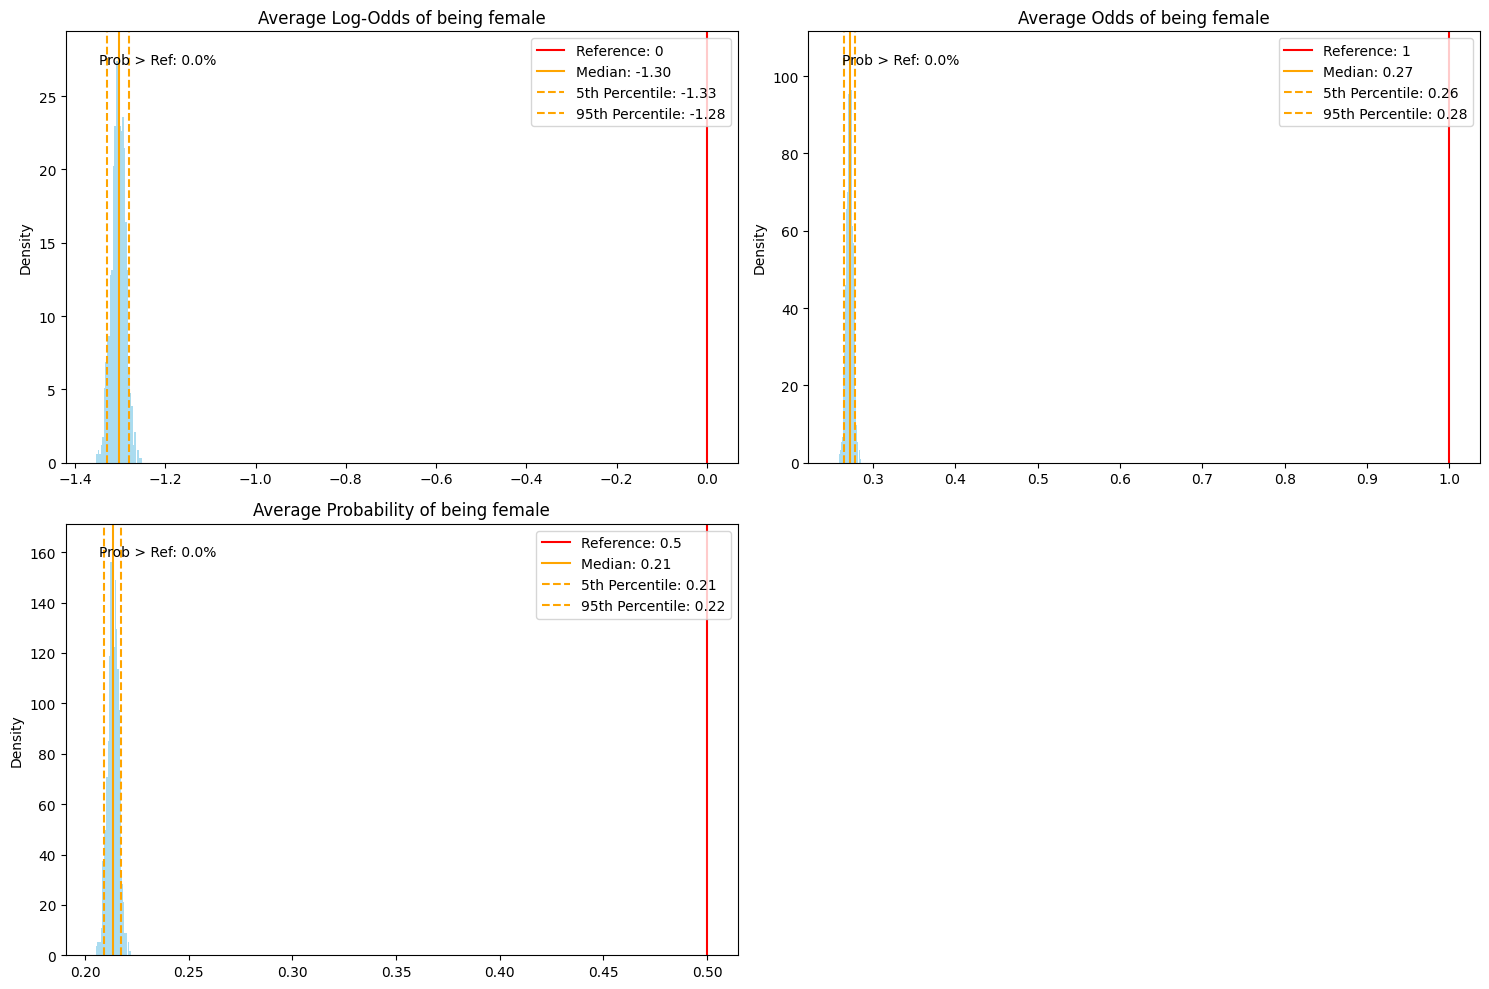

In [10]:
# Calculate statistics for each coefficient
medians = np.median(simulated_base, axis = 0)
lower_quantiles = np.percentile(simulated_base, 5, axis=0)
upper_quantiles = np.percentile(simulated_base, 95, axis=0)
references = [0, 1, 0.5]  # Reference values for log-odds, odds, probability
prob_positive = [np.mean(simulated_base[:, i] > references[i]) for i in range(3)]

# Plot names 
col_names = ['Log-Odds', 'Odds', 'Probability']

# Plot histograms of each metric
fig, axs = plt.subplots(2, 2, figsize=(15, 10))  # Adjust for the number of metrics
axs = axs.flatten()

for i in range(len(col_names)):
    ax = axs[i]
    ax.hist(simulated_base[:, i], bins=30, density=True, alpha=0.7, color='skyblue')
    
    # Add vertical lines for reference, median, and 90% interval
    ax.axvline(references[i], color='red', linestyle='-', label=f'Reference: {references[i]}')
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    ax.text(0.05, 0.95, f'Prob > Ref: {prob_positive[i]*100:.1f}%', transform=ax.transAxes, verticalalignment='top')
    
    ax.set_title(f'Average {col_names[i]} of being female')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

# Hide empty subplot for uneven number of metrics
if len(col_names) % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### Answer: 
MLE of odds of being a female is 0.27, and MLE of probability of being a female is 0.21. Therefore, according to the model there is a higher chance of being a male if the model is homogeneous. The homogeneous model will predict that the gender is male more often than female.

#### ii) The `Heterogeneous Probability` model with one binary covariate: 

In [11]:
aic = model.aic
print("AIC:", aic)

AIC: 24805.861397396347


In [12]:
# Fit the model with college education
# Pale white symmetric possitive semidefinitife error
model = sm.Logit(Y, X_const[['const','Red', 'Black']]).fit()

Optimization terminated successfully.
         Current function value: 0.518740
         Iterations 5


In [13]:
# Get summary results
print(model.summary())

                           Logit Regression Results                           
Dep. Variable:          gender-binary   No. Observations:                23906
Model:                          Logit   Df Residuals:                    23903
Method:                           MLE   Df Model:                            2
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:               7.427e-05
Time:                        11:19:58   Log-Likelihood:                -12401.
converged:                       True   LL-Null:                       -12402.
Covariance Type:            nonrobust   LLR p-value:                    0.3981
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.2804      0.023    -56.040      0.000      -1.325      -1.236
Red           -0.0439      0.042     -1.042      0.297      -0.127       0.039
Black         -0.0422      0.036     -1.176      0.2

In [14]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
coef_mean = model.params
coef_cov = model.cov_params()

In [15]:
# Simulate values of each regression coefficient from the posterior distirbution 
n = 1000
log_odds = multivariate_normal.rvs(mean = coef_mean, cov = coef_cov, size = n)

In [16]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(log_odds)

In [17]:
# Check the range of the odds
[fun(log_odds) for fun in [np.min,np.max]]

[-1.3418147370672522, 0.10717074224650444]

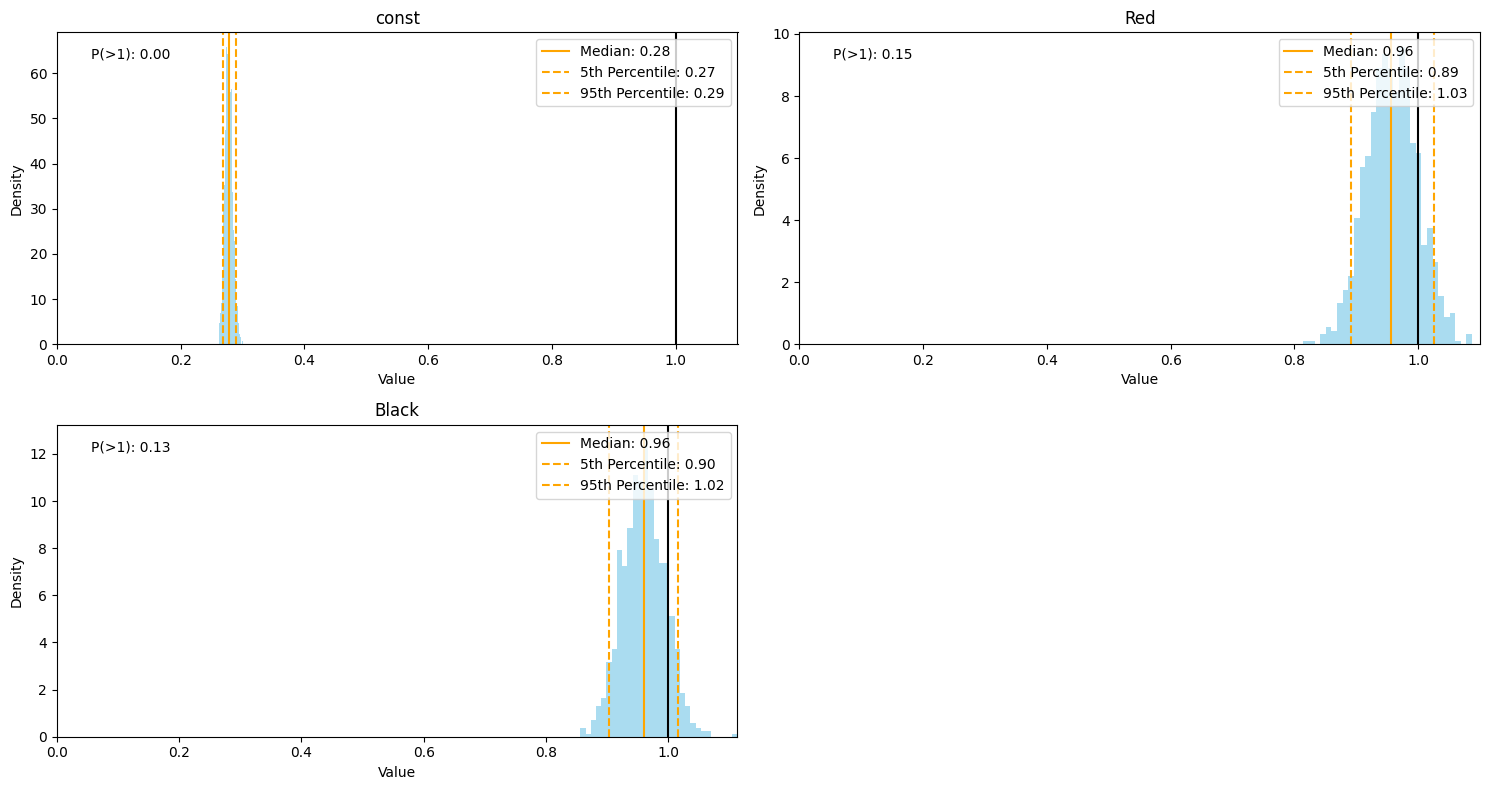

In [18]:
# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = ['const','Red', 'Black']

# Plot histograms of each coefficient
num_rows = (log_odds.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(15, 8))
axs = axs.flatten()

for i in range(log_odds.shape[1]):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(1, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 1
    ax.text(0.05, 0.95, f'P(>1): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{ col_names[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 1 and starts at 0
    ax.set_xlim(left=0, right=max(1.1,abs(simulated_betas_odds[:, i]).max())) 
    
# Hide empty subplot
if log_odds.shape[1] % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()

#### c) Interpret the coefficients.

#### Answer: 

If all covariates are turned to 0, the odds of being a female are 0.28. Owning a red or a black car, decreases chances of being a female by 4%. 

#### d) Get the AIC of this model, and comment on its value compared to the previous model. 

In [19]:
print(model.aic)

24808.019240604142


#### Answer: 

This model performs a little more worse than the homogeneous model

#### ii) The `Heterogeneous Probability` model with multiple covariates and interactions: 

In [20]:
X_const

,const,Acura,Audi,BMW,Buick,Cadillac,Chevrolet,Chrysler,Dodge,Ford,...,Saab,Saturn,Subaru,Toyota,Volkswagen,Volvo,Black,Pale White,Red,Annual income
0,1.0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,-1.135209
1,1.0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0.901622
2,1.0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.283559
3,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,1,0,-1.135209
4,1.0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0.880788
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23901,1.0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-1.135209
23902,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,0.096056
23903,1.0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,-0.174780
23904,1.0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,1,0,0,-1.135209


In [21]:
X_const.columns

Index(['const', 'Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar',
       'Jeep', 'Lexus', 'Lincoln', 'Mercedes-B', 'Mercury', 'Mitsubishi',
       'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Saab',
       'Saturn', 'Subaru', 'Toyota', 'Volkswagen', 'Volvo', 'Black',
       'Pale White', 'Red', 'Annual income'],
      dtype='object')

In [22]:
# Fit the model 
model = sm.Logit(Y, X_const[['const', 'Acura', 'Audi', 'BMW', 'Buick', 'Cadillac', 'Chevrolet',
       'Chrysler', 'Dodge', 'Ford', 'Honda', 'Hyundai', 'Infiniti', 'Jaguar',
       'Jeep', 'Lexus', 'Lincoln', 'Mercedes-B', 'Mercury', 'Mitsubishi',
       'Nissan', 'Oldsmobile', 'Plymouth', 'Pontiac', 'Porsche', 'Saab',
       'Saturn', 'Subaru', 'Toyota', 'Volvo', 'Black',
       'Red', 'Annual income']]).fit()

# Get summary results
print(model.summary())

Optimization terminated successfully.
         Current function value: 0.516424
         Iterations 5
                           Logit Regression Results                           
Dep. Variable:          gender-binary   No. Observations:                23906
Model:                          Logit   Df Residuals:                    23873
Method:                           MLE   Df Model:                           32
Date:                Tue, 02 Apr 2024   Pseudo R-squ.:                0.004539
Time:                        11:20:00   Log-Likelihood:                -12346.
converged:                       True   LL-Null:                       -12402.
Covariance Type:            nonrobust   LLR p-value:                 6.669e-11
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -1.2648      0.068    -18.481      0.000      -1.399      -1.131
Acura             0.

#### b) Simulate the empirical posterior of each coefficient, and plot the histogram of each respective coefficient on the odds-scale:

In [23]:
# Extract the coefficients (betas) and their covariance matrix from the logistic regression fit
beta_mean = model.params
cov_matrix = model.cov_params()


In [24]:
# Simulate values of each regression coefficient from the posterior distirbution 

# Number of simulations
n = 1000
# Simulate beta coefficients
simulated_betas = multivariate_normal.rvs(mean = beta_mean, cov = cov_matrix, size = n)

In [25]:
# Derive odds from log-odds coefficients 
simulated_betas_odds = np.exp(simulated_betas)
print(np.array([fun(simulated_betas_odds) for fun in [np.min,np.max]]))

[0.23395448 1.8332213 ]


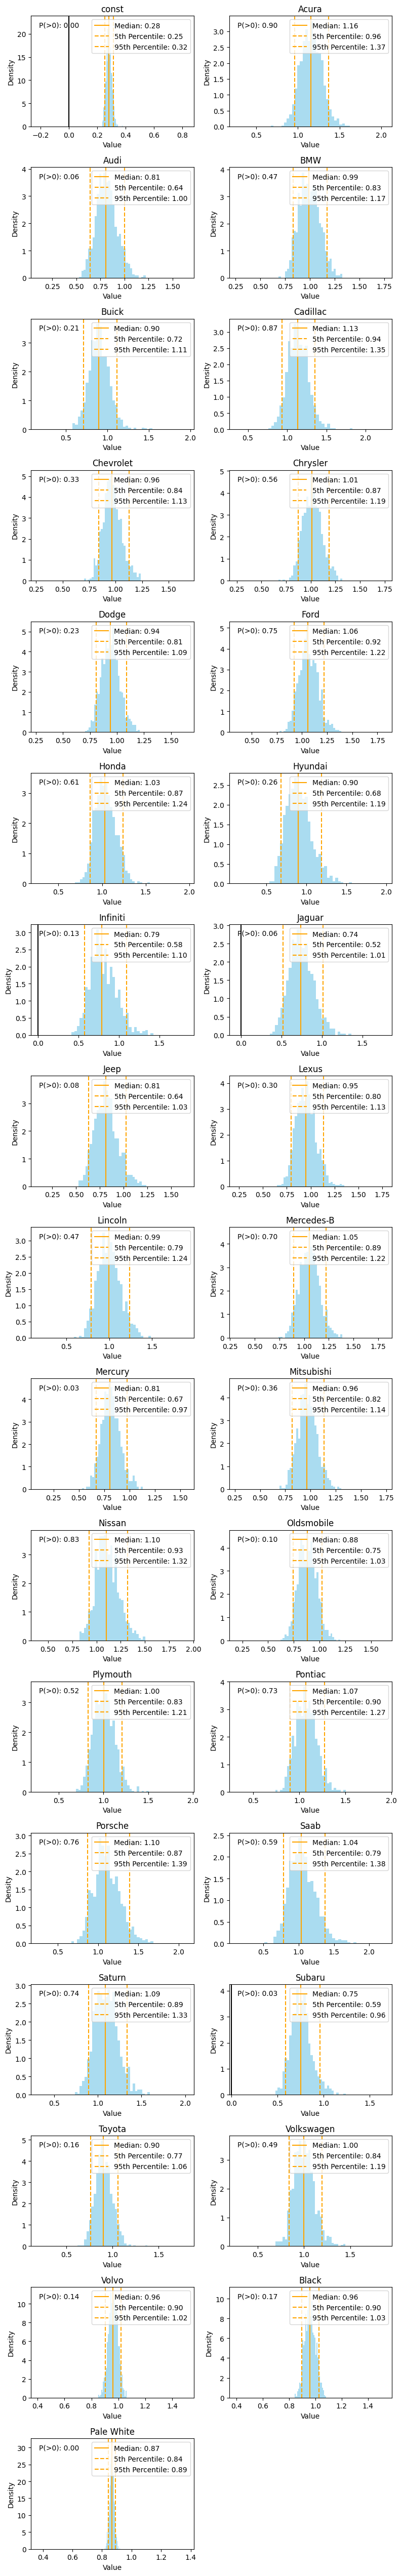

In [26]:

# Calculate statistics for each coefficient
medians = np.median(simulated_betas_odds, axis=0)
lower_quantiles = np.percentile(simulated_betas_odds, 5, axis=0)
upper_quantiles = np.percentile(simulated_betas_odds, 95, axis=0)
prob_positive = np.mean(simulated_betas_odds > 1, axis=0)

# Plot names 
col_names = X_const.columns

# Plot histograms of each coefficient
num_rows = (simulated_betas.shape[1] + 1) // 2  # Adjusted number of rows
fig, axs = plt.subplots(num_rows, 2, figsize=(8, 3*num_rows))
axs = axs.flatten()

# Calculate the number of rows needed for subplots based on the number of coefficients
num_rows = (simulated_betas_odds.shape[0] + 1) // 2

num_coeffs = simulated_betas.shape[1]

for i in range(num_coeffs):
    ax = axs[i]
    ax.hist(simulated_betas_odds[:, i], bins=30, density=True, alpha=0.7, color='skyblue')

    # Add vertical lines for 0
    ax.axvline(0, color='black', linestyle='-')
    
    # Add vertical lines for median and 90% interval
    ax.axvline(medians[i], color='orange', linestyle='-', label=f'Median: {medians[i]:.2f}')
    ax.axvline(lower_quantiles[i], color='orange', linestyle='--', label=f'5th Percentile: {lower_quantiles[i]:.2f}')
    ax.axvline(upper_quantiles[i], color='orange', linestyle='--', label=f'95th Percentile: {upper_quantiles[i]:.2f}')
    
    # Add text annotation for probability above 0
    ax.text(0.05, 0.95, f'P(>0): {prob_positive[i]:.2f}', transform=ax.transAxes, verticalalignment='top', fontsize=10)
    
    ax.set_title(f'{X_const.columns[i]}')
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')
    ax.legend(loc='upper right')

    # Set x-axis limit to ensure it includes 0
    ax.set_xlim([min(simulated_betas_odds[:, i]) - 0.5, max(simulated_betas_odds[:, i]) + 0.5])
    
# Hide empty subplot
if num_coeffs % 2 != 0:
    axs[-1].axis('off')
    
plt.tight_layout()
plt.show()



#### d) Interpret every coefficient in the model. Pay attention to `statistical significance`, and be clear about what the baseline profile over which the effects are calculated is.

#### Answer: 

The intercept captures the baseline odds of a car owner being a female, which is 0.28.
Porche and Nissan are the variables with the highest simulated coefficients -> if the variables are present(1), the odds of being a female increase by 10%.
Owning a Subaru decreases chances of being a woman by 24%

In [27]:
# Finally, let's get the AIC of the model just to compare with what we did before. 
aic = model.aic  
print("AIC:", aic)

AIC: 24757.27852137796
